In [1]:
# You may need to install below packages.
# !pip install pyspark findspark

In [2]:
# It wil set spark environment variable
import findspark
findspark.init()

In [3]:
import os
import pyspark

import pyspark.sql.types as ptypes
import pyspark.sql.functions as funcs

In [4]:
ss = pyspark.sql.SparkSession.builder.master('local[*]').appName('Sales').getOrCreate()

### Updating matpotlib configuration to change figure size

In [5]:
%matplotlib inline
%config InlineBackend.rc = {'figure.figsize': (16, 8)}

In [6]:
sales_path = f'{os.path.abspath(os.path.pardir)}/input/sales-analysis/SalesAnalysis.csv'
sales_data = ss.read.csv(sales_path, inferSchema=True, header=True)

### Dropping null rows

In [7]:
sales_data_dropna = sales_data.dropna()

### Cleaning `Order Date` column

In [8]:
sales_data_dropna = (sales_data_dropna.
                     withColumn('Order Date', funcs.from_unixtime(funcs.unix_timestamp('Order Date', 'MM/dd/yy HH:mm'))))

In [9]:
sales_data_dropna = (sales_data_dropna
                     .withColumn('hour', funcs.date_format(sales_data_dropna['Order Date'], 'HH').cast(ptypes.IntegerType()))
                     .withColumn('minute', funcs.date_format(sales_data_dropna['Order Date'], 'mm').cast(ptypes.IntegerType()))
                     .withColumn('full_weekday', funcs.date_format(sales_data_dropna['Order Date'], 'EEEE'))
                     .withColumn('month_ordered', funcs.date_format(sales_data_dropna['Order Date'], 'MMM')))

### Total number of products sold per month

In [10]:
%matplotlib inline
%config InlineBackend.rc = {'figure.figsize': (16, 8)}

<AxesSubplot:xlabel='Month', ylabel='Quantity'>

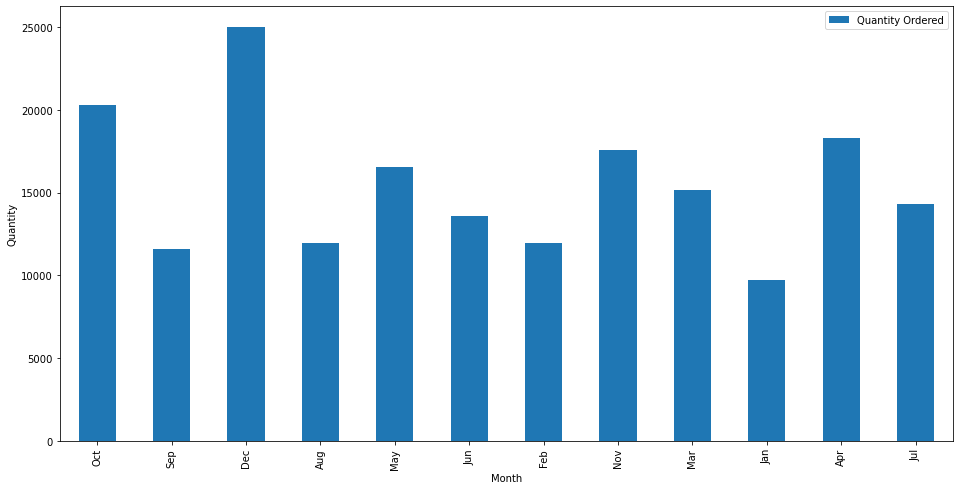

In [11]:
(sales_data_dropna.groupby('month_ordered')
 .agg(
     funcs.count(funcs.col('Quantity Ordered')).alias('Quantity Ordered')
 ).toPandas().plot(kind='bar', x='month_ordered', xlabel="Month", ylabel='Quantity')
)

### Product sold per month

In [12]:
sales_data_dropna = sales_data_dropna.withColumn('total_pay', (funcs.col('Price Each') * funcs.col('Quantity Ordered')))
monthly_highest_sales = sales_data_dropna.groupby('month_ordered').sum('total_pay').alias('monthly_total')
monthly_highest_sales = monthly_highest_sales.withColumnRenamed('sum(total_pay)', 'monthly_total')

<AxesSubplot:xlabel='Month', ylabel='Sales in USD ($)'>

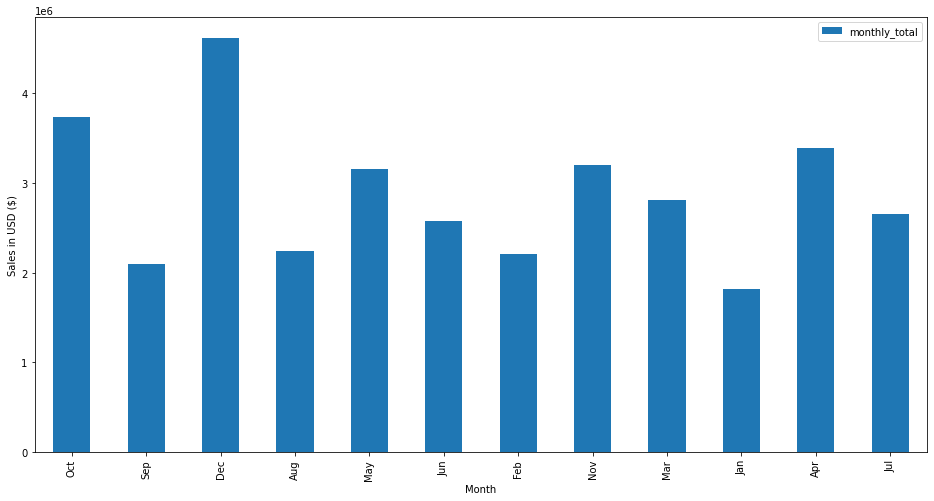

In [13]:
(monthly_highest_sales.toPandas()
 .plot(kind='bar', x='month_ordered', xlabel='Month', ylabel='Sales in USD ($)'))

### What are the products sold in large amount?

<AxesSubplot:xlabel='Products', ylabel='Quantity Ordered'>

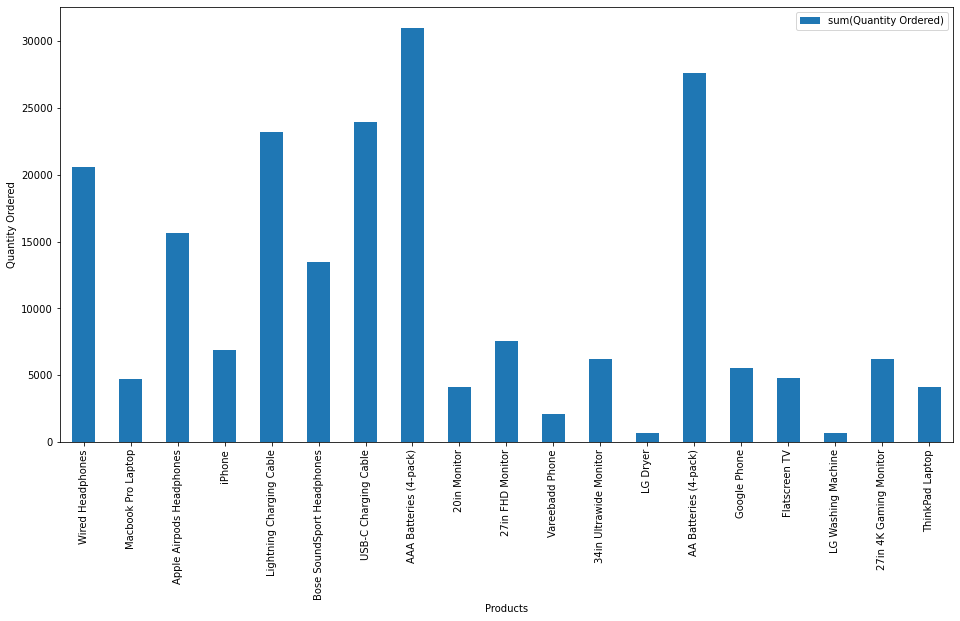

In [14]:
(sales_data_dropna.groupby('Product')
 .agg({'Quantity Ordered': 'sum'})
 .toPandas().plot(kind='bar', x='Product', xlabel='Products', ylabel='Quantity Ordered'))

### Defining `UDF` function to clean address

In [15]:
def clean_addresss(address):
    city = address.split(',')[1].strip()
    state = address.split(',')[2].split(' ')[1].strip()
    return f'{city} ({state})'

clean_addresss_udf = funcs.udf(lambda addrs: clean_addresss(addrs))

In [16]:
# Cleaning address
sales_data_dropna = sales_data_dropna.withColumn('city', clean_addresss_udf('Purchase Address'))

### Total Sales per city

<AxesSubplot:xlabel='City', ylabel='Sales in USD ($)'>

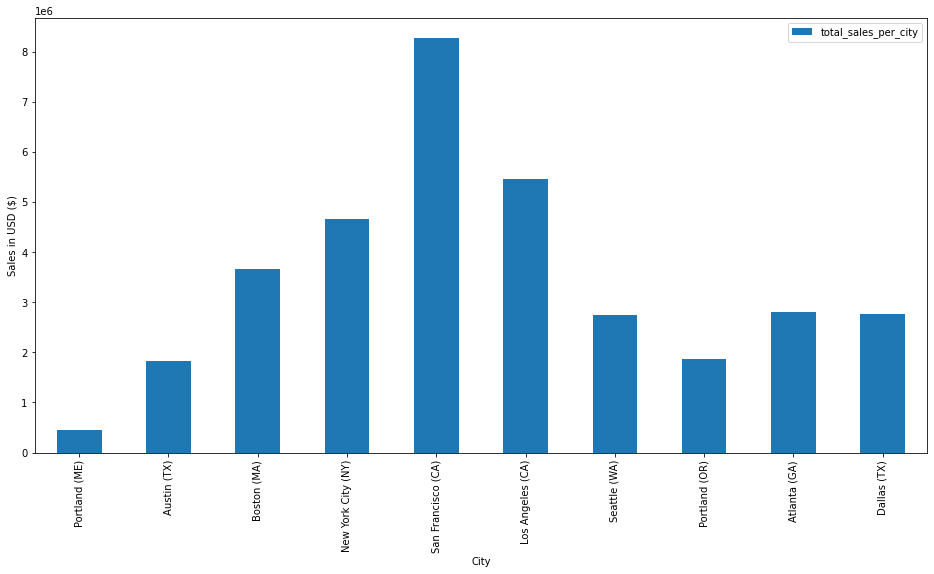

In [17]:
(sales_data_dropna.groupBy('city').sum('total_pay')
 .withColumnRenamed('sum(total_pay)', 'total_sales_per_city')
 .toPandas().plot(kind='bar', x='city', xlabel='City', ylabel='Sales in USD ($)'))

### Max sales during specific hour

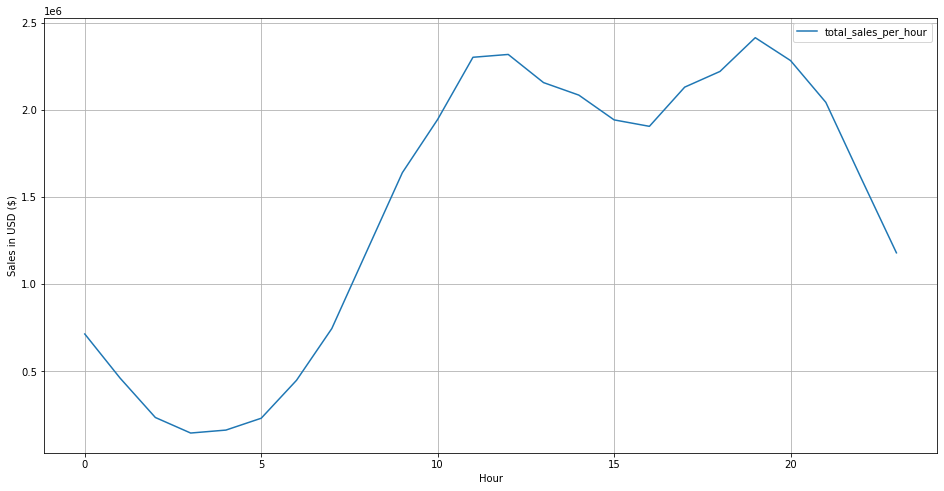

In [18]:
(sales_data_dropna.groupby('hour')
 .sum('total_pay').withColumnRenamed('sum(total_pay)', 'total_sales_per_hour')
 .sort('hour').toPandas().plot(x='hour', xlabel='Hour', ylabel='Sales in USD ($)')
 .grid())

### Find the day of week for entire year which has max product selling.

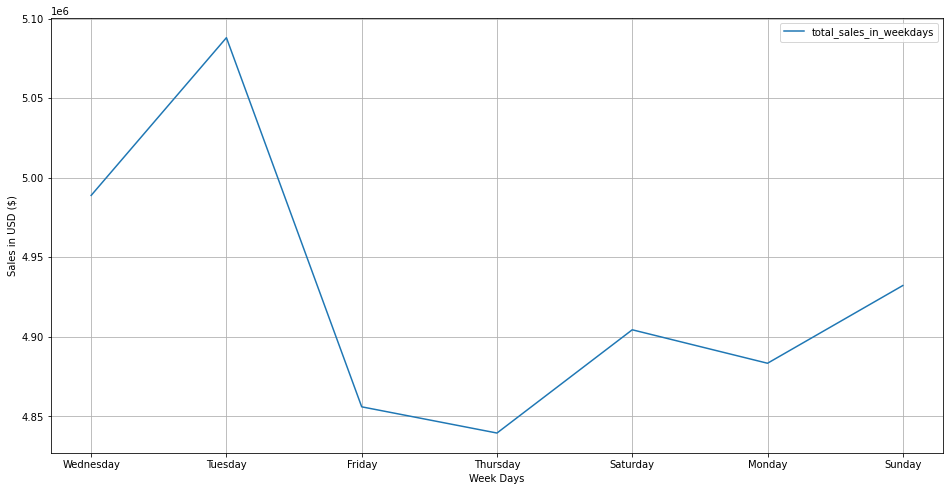

In [19]:
(sales_data_dropna.groupby('full_weekday').sum('total_pay')
 .withColumnRenamed('sum(total_pay)', 'total_sales_in_weekdays')
 .toPandas().plot(x='full_weekday', xlabel='Week Days', ylabel='Sales in USD ($)')
 .grid())

### What are the product sold on `Tuesday`? and How many of each product sold on `Tuesday`?

In [20]:
colmns = ['full_weekday']
(sales_data_dropna.groupby('Product').agg(
    funcs.sum(funcs.col('Quantity Ordered')).alias('total_no_of_items_orderd_in_year'),
    *[funcs.first(cl).alias(cl) for cl in colmns]
).where(funcs.col('full_weekday') == 'Tuesday')
 .select('Product', 'total_no_of_items_orderd_in_year')
 .sort('total_no_of_items_orderd_in_year', ascending=False).show())

+--------------------+--------------------------------+
|             Product|total_no_of_items_orderd_in_year|
+--------------------+--------------------------------+
|              iPhone|                            6849|
|27in 4K Gaming Mo...|                            6244|
|     ThinkPad Laptop|                            4130|
|        20in Monitor|                            4129|
|  LG Washing Machine|                             666|
+--------------------+--------------------------------+



### Check the records which has duplicates Ordered ID's

In [21]:
multiple_item_id_order = (sales_data_dropna.groupby('Order ID').count().where(funcs.col('count') > 1)
                          .sort('count', ascending=False).withColumnRenamed('count', 'total_item_in_order'))
multiple_item_id_order.count()

7136

In [22]:
sales_data_dropna_tmp = sales_data_dropna
multiple_item_order_data = multiple_item_id_order.join(sales_data_dropna_tmp, ['Order ID'], 'leftouter')
multiple_item_order_data.count()

14649

### What are the products sold togather?

In [23]:
multiple_item_order_data_grouped = (multiple_item_order_data.groupby('Order ID')
 .agg(
     funcs.concat_ws(", ", funcs.collect_list(funcs.col('Product'))).alias('items_in_a_order'),
     *[funcs.first(cl).alias(cl) for cl in multiple_item_order_data.columns if not cl == 'Order ID']
 )
)

In [24]:
multiple_item_order_data_grouped.groupby('items_in_a_order').count().sort('count', ascending=False).show(5)

+--------------------+-----+
|    items_in_a_order|count|
+--------------------+-----+
|Lightning Chargin...|  882|
|USB-C Charging Ca...|  856|
|Wired Headphones,...|  361|
|USB-C Charging Ca...|  312|
|Wired Headphones,...|  303|
+--------------------+-----+
only showing top 5 rows

